# Overview

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

# Problem Statement : To identify duplicate questions

The goal is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts.

# Evaluation

On the basis of log loss between the predicted values and the ground truth.



# Reason of performing such task:

* Lot of redundant similar questions.
* The cost of a mis-classification can be very high.

# Data

* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

# Loading Dataset

In [0]:
# importing libraries

import re
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize 
from nltk import FreqDist
fdist = FreqDist
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd 
import re
from io import StringIO
import os
import glob
import numpy as np
from collections import defaultdict
from pathlib import Path


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# creating pandas Dataframe 
df = pd.read_csv(r"D:\Downloads\train.csv")
dfcopy=df.copy(deep=True)

In [0]:
# taking 10000 data points as time is a constraint
df = df.iloc[:10000,]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
id              10000 non-null int64
qid1            10000 non-null int64
qid2            10000 non-null int64
question1       10000 non-null object
question2       10000 non-null object
is_duplicate    10000 non-null int64
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


# Exploratory data analysis

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

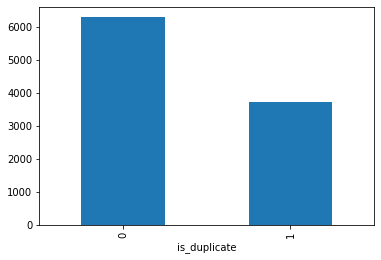

In [0]:
# not an imbalance set
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('Data point with class',df.groupby('is_duplicate')['id'].count())

Data point with class is_duplicate
0    6289
1    3711
Name: id, dtype: int64


# Basic Feature engineering

In [0]:
# frequencies of both questions
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

In [0]:
sque1=[]
for ele in df['question1']:
    ele = ele.lower()
    sque1.append(ele)
sque2=[]
for ele in df['question2']:
    ele = ele.lower()
    sque2.append(ele)
for i in range(10000):
    sque1[i] = sque1[i].split()
    sque2[i] = sque2[i].split()

In [0]:
# using common word count between both questions as a feature
commonwords=[]
commoncount=[]
for i in range(10000):
    commonwords.append(list(set(sque1[i]).intersection(sque2[i])))
    commoncount.append(len(commonwords[i]))
df['commoncount']=commoncount

In [0]:
# Word share is ratio between common words in 2 questions and total words in 2 questions
wordshare=[]
for i in range(10000):
    wordshare.append(((commoncount[i]))/((len(set(sque1[i])))+(len(set(sque2[i])))))

In [0]:
df['wordshare']= wordshare

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,commoncount,wordshare
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,10,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,4,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,4,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,2,0.100000


# Advanced Feature engineering

In [0]:
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
df["token_set_ratio"] = df.apply(lambda dfcopy: fuzz.token_set_ratio(dfcopy["question1"], dfcopy["question2"]), axis=1)
df.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,10,0.434783,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,4,0.200000,86
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,4,0.166667,63
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,0,0.000000,28
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,2,0.100000,67


In [0]:
df["token_sort_ratio"]      = df.apply(lambda dfcopy: fuzz.token_sort_ratio(dfcopy["question1"], dfcopy["question2"]), axis=1)
df["fuzz_ratio"]            = df.apply(lambda dfcopy: fuzz.QRatio(dfcopy["question1"], dfcopy["question2"]), axis=1)


In [0]:
df["fuzz_partial_ratio"]    = df.apply(lambda dfcopy: fuzz.partial_ratio(dfcopy["question1"], dfcopy["question2"]), axis=1)
#df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(dfcopy["question1"], dfcopy["question2"]), axis=1)

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,10,0.434783,100,93,93,98
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,4,0.200000,86,63,66,73
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,4,0.166667,63,63,43,41
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,0,0.000000,28,24,9,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,2,0.100000,67,47,35,54


In [0]:
que1=[]
for ele in df['question1']:
    ele = ele.lower()
    que1.append(ele)
que2=[]
for ele in df['question2']:
    ele = ele.lower()
    que2.append(ele)
print(type(que1[0]))

<class 'str'>


In [0]:
for i in range(10000):
    que1[i] = re.sub(r'\d+', '', que1[i])
    que2[i] = re.sub(r'\d+', '', que2[i])
print(type(que1[0]))

<class 'str'>


In [0]:
for i in range(10000):
    que1[i] = que1[i].replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    que2[i] = que2[i].replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    que1[i] = re.sub(r"([0-9]+)000000", r"\1m", que1[i])
    que2[i] = re.sub(r"([0-9]+)000", r"\1k", que2[i])

In [0]:
for i in range(10000):
    que1[i] = que1[i].split()
    que2[i] = que2[i].split()

In [0]:
for i in range(10000):
    table = str.maketrans('', '', string.punctuation)
    que1[i] = [w.translate(table) for w in que1[i]]
    que2[i] = [w.translate(table) for w in que2[i]]

In [0]:
lemmatizer = WordNetLemmatizer()
for i in range(10000):
    que1[i] = [lemmatizer.lemmatize(word) for word in que1[i]]
    que2[i] = [lemmatizer.lemmatize(word) for word in que2[i]]

In [0]:
stop_words = set(stopwords.words('english'))
for i in range(10000):
    que1[i]= [w for w in que1[i] if not w in stop_words]
    que2[i]= [w for w in que2[i] if not w in stop_words]

In [0]:
df['que1']=que1
df['que2']=que2
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,que1,que2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,10,0.434783,100,93,93,98,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,4,0.200000,86,63,66,73,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,4,0.166667,63,63,43,41,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,0,0.000000,28,24,9,20,"[mentally, lonely, solve]","[find, remainder, mathmath, divided, ]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,2,0.100000,67,47,35,54,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [0]:
df['text']=df['que1']+df['que2']
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,que1,que2,text
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,10,0.434783,100,93,93,98,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]","[step, step, guide, invest, share, market, ind..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,4,0.200000,86,63,66,73,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...","[story, kohinoor, kohinoor, diamond, would, ha..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,4,0.166667,63,63,43,41,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]","[increase, speed, internet, connection, using,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,0,0.000000,28,24,9,20,"[mentally, lonely, solve]","[find, remainder, mathmath, divided, ]","[mentally, lonely, solve, find, remainder, mat..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,2,0.100000,67,47,35,54,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]","[one, dissolve, water, quikly, sugar, salt, me..."


In [0]:
dfcopy2=df.copy(deep=True)

# creating tf-idf wordvec using glove

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df2 = pd.DataFrame(vecs1)



  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

  0%|                                                                               | 10/10000 [00:00<01:40, 99.24it/s]

  0%|▏                                                                             | 22/10000 [00:00<01:38, 100.99it/s]

  0%|▏                                                                              | 31/10000 [00:00<01:42, 97.42it/s]

  0%|▎                                                                              | 40/10000 [00:00<01:45, 94.74it/s]

  0%|▍                                                                              | 50/10000 [00:00<01:48, 92.11it/s]

  1%|▍                                                                              | 60/10000 [00:00<01:47, 92.69it/s]

  1%|▌                                                                              | 71/10000 [00:00<01:43, 96.08it/s]

  1%|▋                        

In [0]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df3 = pd.DataFrame(vecs2)



  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

  0%|                                                                              | 11/10000 [00:00<01:31, 109.47it/s]

  0%|▏                                                                             | 23/10000 [00:00<01:32, 107.86it/s]

  0%|▎                                                                             | 33/10000 [00:00<01:35, 104.76it/s]

  0%|▎                                                                             | 46/10000 [00:00<01:32, 107.50it/s]

  1%|▍                                                                             | 56/10000 [00:00<01:35, 104.04it/s]

  1%|▌                                                                             | 67/10000 [00:00<01:34, 104.64it/s]

  1%|▌                                                                             | 80/10000 [00:00<01:31, 107.88it/s]

  1%|▋                        

In [0]:
df2.head()


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-18.169328,30.291894,-131.019382,-132.832186,52.773136,90.446342,17.889316,-5.136500,-61.633417,-151.677849,...,-86.818182,102.732240,23.396822,74.324522,-15.950977,-2.446372,142.460270,-140.064669,13.560669,-20.975797
1,-92.056045,63.323298,-119.210055,-112.559223,-23.633730,64.232543,26.058900,13.473866,-5.487462,-33.620939,...,-129.252660,51.448873,95.841724,60.643368,-113.542859,4.836915,58.166413,-107.072950,-63.384746,19.631405
2,-97.784637,-105.097354,-86.326778,-135.764273,62.345729,56.560755,5.073073,38.648748,25.529308,-58.337663,...,-111.917425,125.349819,38.909950,90.567466,-54.875866,39.308835,-8.586312,-121.800170,-1.746804,-4.993286
3,11.816890,-69.924871,-103.842888,-32.609174,26.161462,142.011983,8.216657,38.242002,-22.385116,-46.465297,...,65.600832,25.147224,-71.774611,27.014048,49.387655,-88.450152,31.193001,-66.114093,-84.177356,6.307693
4,-81.509106,-6.191610,-172.300680,-202.626032,131.126451,13.170784,-35.695247,92.018350,73.769151,-193.118219,...,-118.532251,154.667917,30.238365,135.267189,-24.900389,126.898659,105.413766,-157.939442,-50.799389,-147.948748


In [0]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-27.751557,14.083631,-109.590791,-122.127774,55.546568,96.877506,35.520992,-8.291393,-47.162168,-135.116599,...,-63.562185,95.936760,13.802004,90.274471,-3.297753,-28.880486,103.906652,-119.059004,-14.814117,-14.095521
1,-22.855300,70.450672,-154.446743,-206.009872,-43.566679,89.359803,-122.200737,-1.413121,-11.480187,-43.928967,...,-123.057898,97.879051,44.826806,63.426253,-119.234914,6.474963,55.949210,-146.928822,-84.750293,13.726559
2,-50.751859,7.235098,-140.336283,-73.808995,4.255739,37.019611,-82.281116,73.004437,25.209968,19.593793,...,-115.320462,124.835102,42.869936,5.576358,-53.125206,-7.529513,31.963857,-11.140764,-34.028236,28.263589
3,-28.771259,25.579322,-122.318967,-56.490220,12.293162,91.128054,-4.506637,-7.718663,16.213228,-1.634934,...,-89.874849,83.468354,-60.951159,-8.997315,-59.411441,-14.560466,97.068011,18.442745,-62.854083,-21.375730
4,-28.065125,-47.242234,-91.054907,-73.766392,69.149538,81.785132,-25.051580,47.890587,-0.462245,-101.651004,...,19.003583,41.147766,-60.008308,16.931324,-15.647028,8.772499,75.636810,-77.645903,24.905338,-26.534069


In [0]:
dfcopy3=df.copy(deep=True)
dfcopy4=df.copy(deep=True)
dfcopy5=df.copy(deep=True)

In [0]:
df4 = dfcopy3.drop(['qid1','qid2','question1','question2','is_duplicate','que1','que2','text'],axis=1)
df4.head()

,id,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,1,10,0.434783,100,93,93,98
1,1,1,1,4,0.200000,86,63,66,73
2,2,1,1,4,0.166667,63,63,43,41
3,3,1,1,0,0.000000,28,24,9,20
4,4,1,1,2,0.100000,67,47,35,54


In [0]:
df2['id']=df4['id']
df3['id']=df4['id']

In [0]:
df5 = df4.merge(df2, on='id',how='left')

In [0]:
df5.head()

,id,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,0,...,86,87,88,89,90,91,92,93,94,95
0,0,1,1,10,0.434783,100,93,93,98,-18.169328,...,-86.818182,102.732240,23.396822,74.324522,-15.950977,-2.446372,142.460270,-140.064669,13.560669,-20.975797
1,1,1,1,4,0.200000,86,63,66,73,-92.056045,...,-129.252660,51.448873,95.841724,60.643368,-113.542859,4.836915,58.166413,-107.072950,-63.384746,19.631405
2,2,1,1,4,0.166667,63,63,43,41,-97.784637,...,-111.917425,125.349819,38.909950,90.567466,-54.875866,39.308835,-8.586312,-121.800170,-1.746804,-4.993286
3,3,1,1,0,0.000000,28,24,9,20,11.816890,...,65.600832,25.147224,-71.774611,27.014048,49.387655,-88.450152,31.193001,-66.114093,-84.177356,6.307693
4,4,1,1,2,0.100000,67,47,35,54,-81.509106,...,-118.532251,154.667917,30.238365,135.267189,-24.900389,126.898659,105.413766,-157.939442,-50.799389,-147.948748


In [0]:
df5 = df5.merge(df3, on='id',how='left')

In [0]:
df5.head()

,id,freq_qid1,freq_qid2,commoncount,wordshare,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,0_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,1,10,0.434783,100,93,93,98,-18.169328,...,-63.562185,95.936760,13.802004,90.274471,-3.297753,-28.880486,103.906652,-119.059004,-14.814117,-14.095521
1,1,1,1,4,0.200000,86,63,66,73,-92.056045,...,-123.057898,97.879051,44.826806,63.426253,-119.234914,6.474963,55.949210,-146.928822,-84.750293,13.726559
2,2,1,1,4,0.166667,63,63,43,41,-97.784637,...,-115.320462,124.835102,42.869936,5.576358,-53.125206,-7.529513,31.963857,-11.140764,-34.028236,28.263589
3,3,1,1,0,0.000000,28,24,9,20,11.816890,...,-89.874849,83.468354,-60.951159,-8.997315,-59.411441,-14.560466,97.068011,18.442745,-62.854083,-21.375730
4,4,1,1,2,0.100000,67,47,35,54,-81.509106,...,19.003583,41.147766,-60.008308,16.931324,-15.647028,8.772499,75.636810,-77.645903,24.905338,-26.534069


In [0]:
result=df5
result.to_csv('final_features.csv')

# Train and Test data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [0]:
dfcopy3.head()
y_true = list(dfcopy3['is_duplicate'])

In [0]:
df5=df5.drop(['id'],axis=1)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(df5, y_true, stratify=y_true, test_size=0.3)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 200)
Number of data points in test data : (3000, 200)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6288571428571429 Class 1:  0.37114285714285716
---------- Distribution of output variable in test data ----------
Class 0:  0.371 Class 1:  0.371


# Logistic Regression with hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [0]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

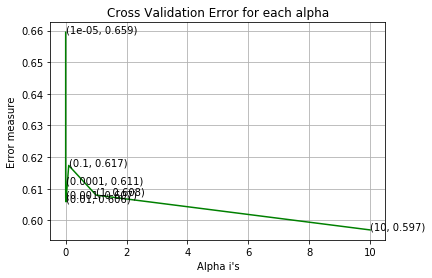

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  10 The train log loss is: 0.584986500885929
For values of best alpha =  10 The test log loss is: 0.5969743694691668
Total number of data points : 3000


# XGBoost 

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=40, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.687299	valid-logloss:0.687316
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 40 rounds.
[10]	train-logloss:0.639333	valid-logloss:0.6398
[20]	train-logloss:0.604284	valid-logloss:0.606349
[30]	train-logloss:0.577799	valid-logloss:0.581952
[40]	train-logloss:0.556991	valid-logloss:0.563088
[50]	train-logloss:0.540624	valid-logloss:0.54834
[60]	train-logloss:0.527383	valid-logloss:0.537103
[70]	train-logloss:0.516175	valid-logloss:0.528199
[80]	train-logloss:0.506663	valid-logloss:0.521075
[90]	train-logloss:0.498481	valid-logloss:0.515362
[100]	train-logloss:0.491194	valid-logloss:0.510334
[110]	train-logloss:0.485097	valid-logloss:0.506047
[120]	train-logloss:0.479369	valid-logloss:0.502719
[130]	train-logloss:0.474285	valid-logloss:0.499961
[140]	train-logloss:0.470104	valid-logloss:0.497785
[150]	train-logloss:0.466311	valid-logloss:0.49557
[160]	train-logloss:0.46283	vali

# Coclusion
- Log loss obtained using XGBoost model is less than Logistic regression model. Hence, in this problem XGBoost model performs better.